In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import seaborn as sns
import xgboost as xgb 
import lightgbm as lgbm
import catboost as catb

from scipy.stats import mannwhitneyu
from scipy.stats import mode

import warnings

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})
pd.options.display.max_columns = 100

In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
TRAIN_DATASET_PATH = ('C:\\Users\\4а\\course_project_train.csv')
TEST_DATASET_PATH = ('C:\\Users\\4а\\course_project_test.csv')

# Изучение данных #

Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [8]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


# Обработка выбросов и пропусков #

In [9]:
Target_name = 'Credit Default'
Feature_names = train_df.columns.drop(Target_name).tolist()
Catfeature_names = train_df.select_dtypes(include='object').columns.tolist()
Numfeatures_names = list(set(Feature_names) - set(Catfeature_names))

Построим гистограммы признаков


array([[<AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Annual Income'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>],
       [<AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Credit Score'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>],
       [<AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>]],
      dtype=object)

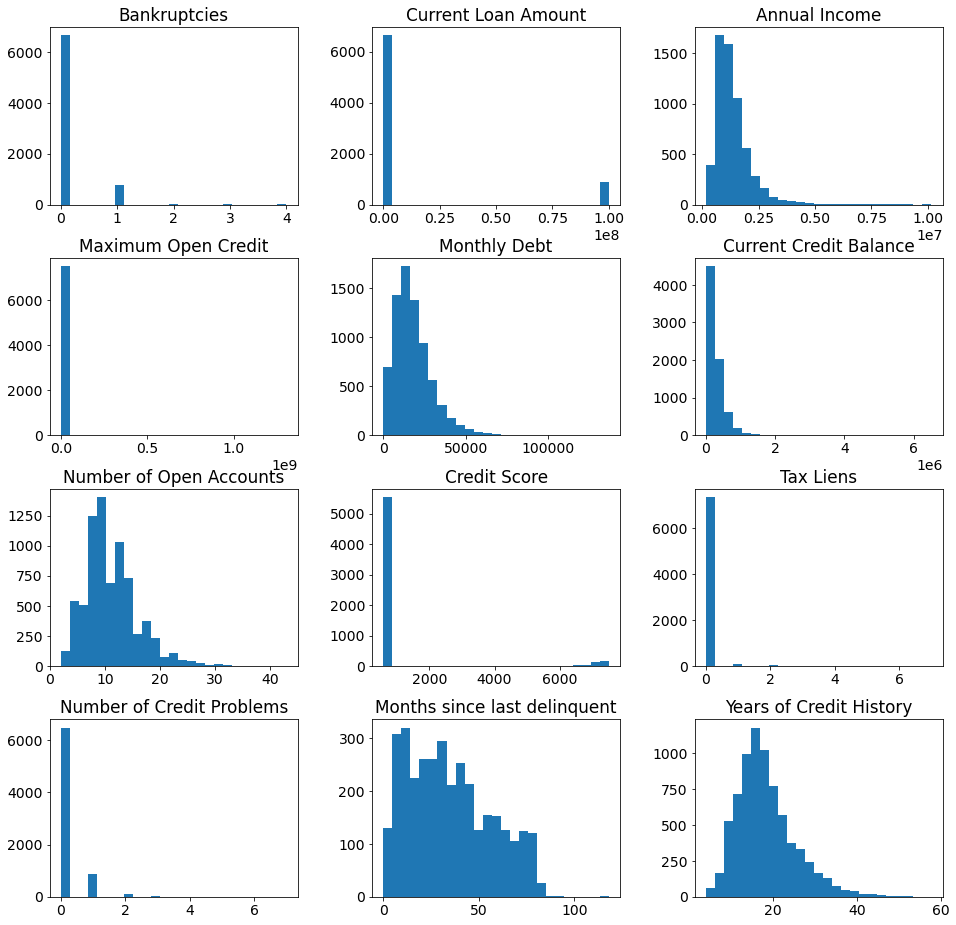

In [10]:
train_df[Numfeatures_names].hist(figsize=(16,16), bins=25, grid=False)

Есть пропуски в полях Maximum Open Credit, Current Loan Amount, Credit Score

Корреляционная матрица

Матрица корреляций признаков и целевой переменной

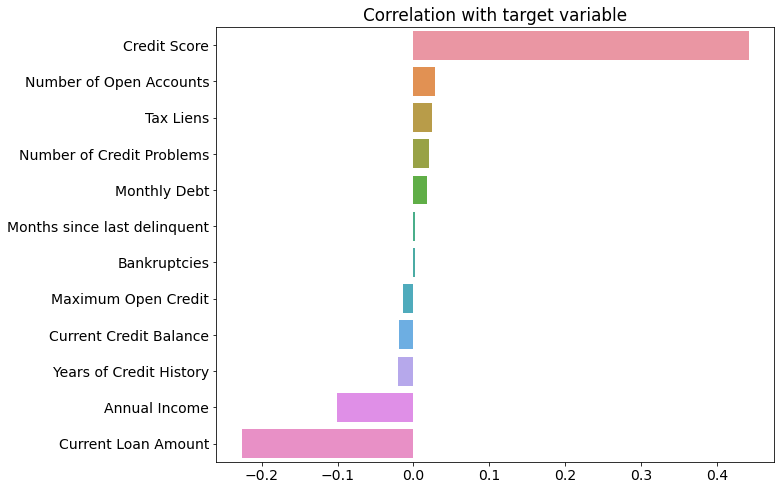

In [11]:
correlation_with_target = train_df[Feature_names + [Target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)

plt.title('Correlation with target variable')
plt.show()

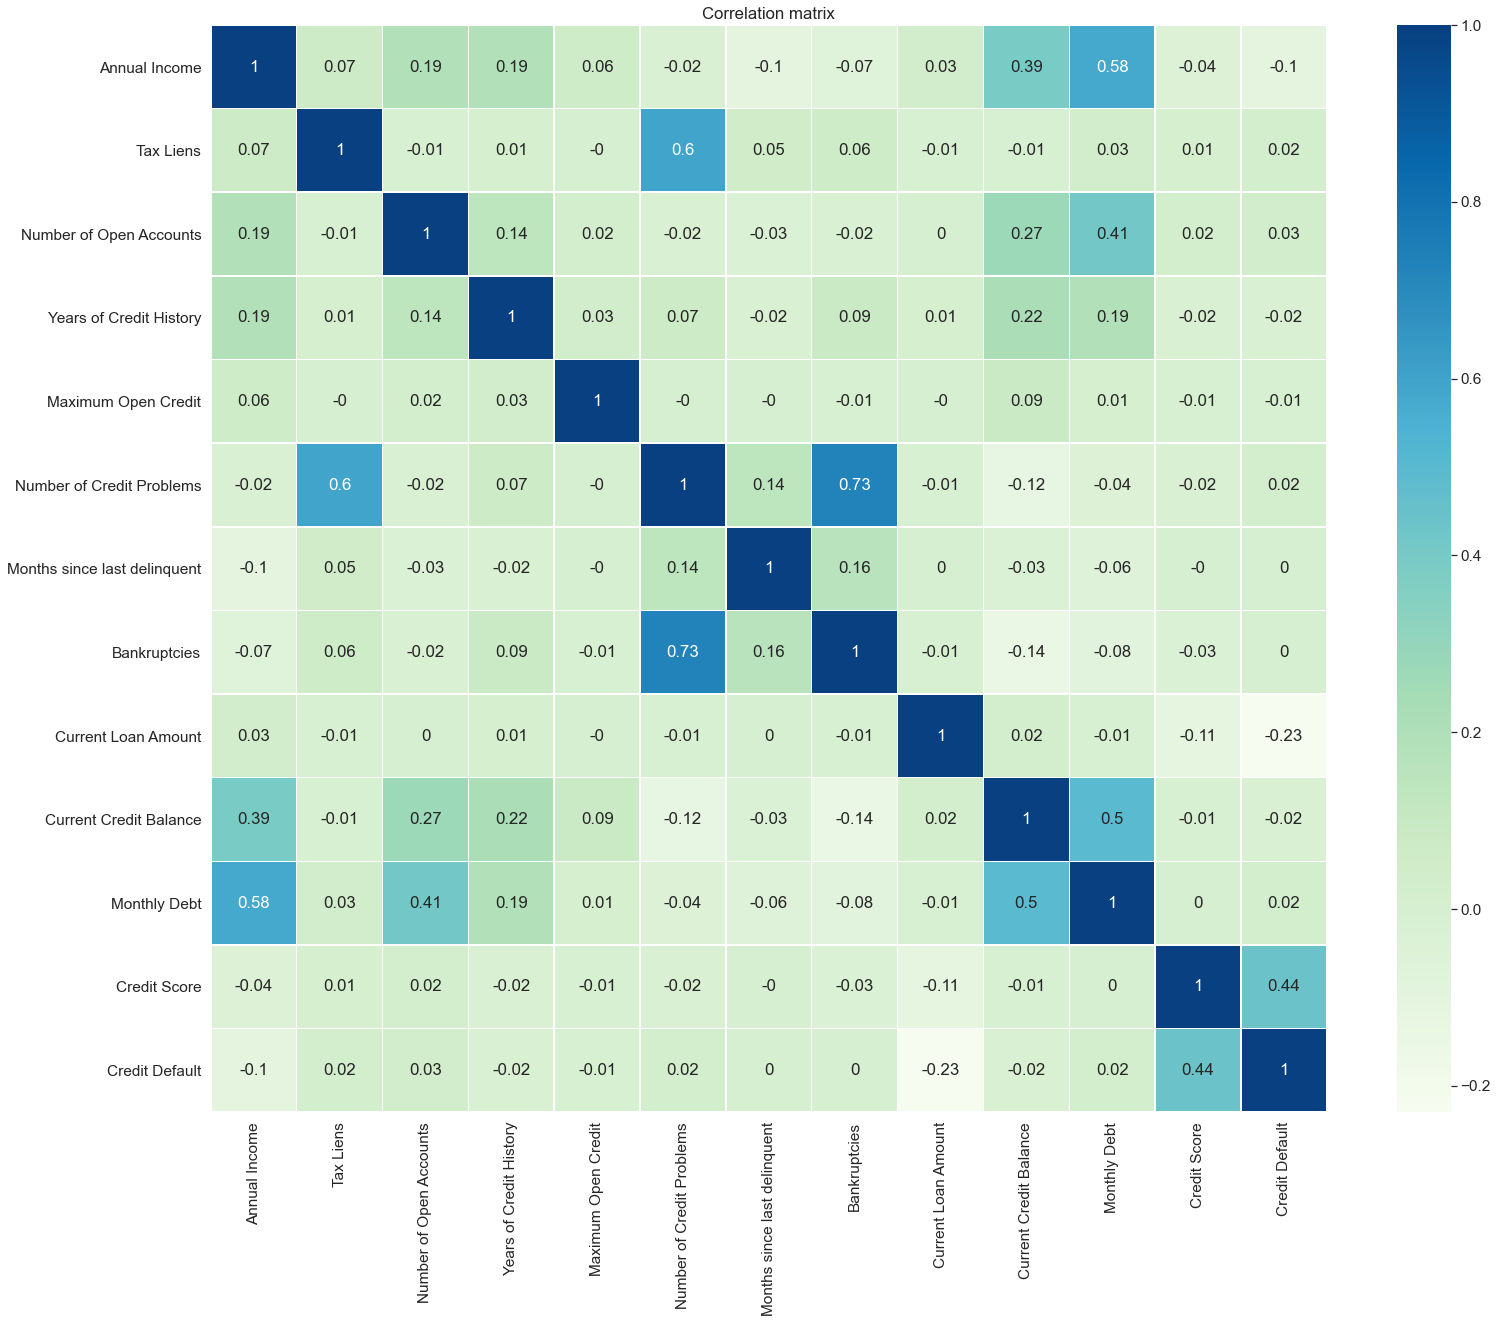

In [12]:
plt.figure(figsize=(25,20))

sns.set(font_scale=1.4)
correlation_matrix = train_df[Feature_names + [Target_name]].corr()
correlation_matrix = np.round(correlation_matrix, 2)

sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из графиков видно, что влияние на целевую переменную больше всех оказывают признаки Credit Score и Current Loan Amount


Maximum Open Credit


In [13]:
train_df.nlargest(10, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
7026,Home Mortgage,3312365.0,5 years,0.0,13.0,25.3,2.640700e+07,0.0,50.0,0.0,home improvements,Long Term,99999999.0,2440246.0,39196.0,745.0,0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,2.634333e+07,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,2.137243e+07,0.0,0.0,0.0,other,Long Term,99999999.0,1975012.0,12555.0,728.0,0
5731,Home Mortgage,1475198.0,8 years,0.0,10.0,24.9,1.928043e+07,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1132286.0,17543.0,751.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


Значения Maximum Open Credit различаются на порядок, поэтому надо решить проблему выброса

In [14]:
max_credit = 99999999.0
train_df['Maximum Open Credit. Outlier'] = 0
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

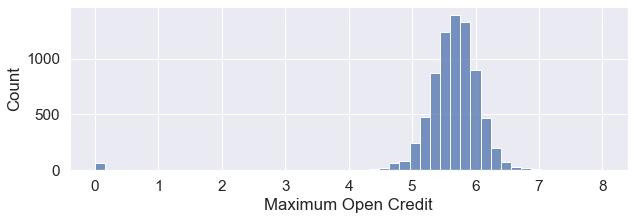

In [15]:
plt.figure(figsize = (10, 3))
sns.histplot(data=np.log10(train_df['Maximum Open Credit'] + 1), bins=50);

Теперь Maximum Open Credit выглядит более правдоподобно, но мы заменим бывшие выбросные значения на медиану и пометим нулевые значения

In [16]:
train_df['Maximum Open Credit. Outlier'] = 0
train_df.loc[train_df['Maximum Open Credit'] > 99999999, 'Maximum Open Credit. Outlier'] = 1
train_df.loc[train_df['Maximum Open Credit'] > 99999999, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Maximum Open Credit. Outlier,Maximum Open Credit Outlier
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.0,3.0
mean,1.366392e+06,0.030133,11.130933,18.317467,7.251149e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733,0.0,1.0
std,8.453392e+05,0.271604,4.908924,7.041946,2.353864e+06,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874,0.0,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.0,1.0
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000,0.0,1.0
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,0.0,1.0
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000,0.0,1.0
max,1.014934e+07,7.000000,43.000000,57.700000,1.000000e+08,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,0.0,1.0


Current Loan Amount

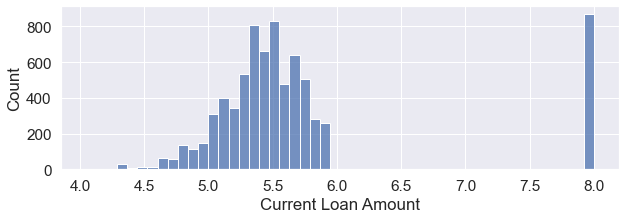

In [17]:
plt.figure(figsize = (10, 3))
sns.histplot(data=np.log10(train_df['Current Loan Amount'] + 1), bins=50);

На графике видно, что максимальные значения - аномальны, надо исправить

In [18]:
train_df['Current Loan Amount. Outlier'] = 0
CLM_condition = train_df['Current Loan Amount'] >= 99999999.0
train_df.loc[CLM_condition, 'Current Loan Amount. Outlier'] = 1
train_df.loc[CLM_condition, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Maximum Open Credit. Outlier,Maximum Open Credit Outlier,Current Loan Amount. Outlier
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.000000,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.0,3.0,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,7.251149e+05,0.170000,34.692600,0.117152,309088.029067,2.898332e+05,18314.454133,1151.087498,0.281733,0.0,1.0,0.116000
std,8.453392e+05,0.271604,4.908924,7.041946,2.353864e+06,0.498598,21.688806,0.347192,171393.740131,3.178714e+05,11926.764673,1604.451418,0.449874,0.0,0.0,0.320246
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.0,1.0,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.000000,1.142565e+05,10067.500000,711.000000,0.000000,0.0,1.0,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309567.500000,2.093230e+05,16076.500000,731.000000,0.000000,0.0,1.0,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,396929.500000,3.604062e+05,23818.000000,743.000000,1.000000,0.0,1.0,0.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.000000e+08,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000,0.0,1.0,1.000000


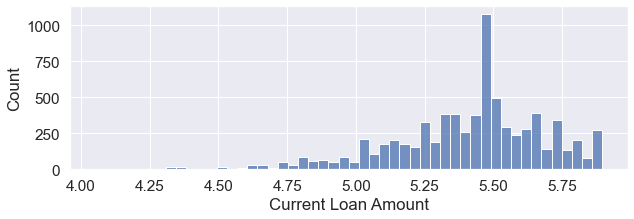

In [19]:
plt.figure(figsize = (10, 3))
sns.histplot(data=np.log10(train_df['Current Loan Amount'] + 1), bins=50);

Значения уже выглядят логичнее

Credit Score

<AxesSubplot:xlabel='Credit Score', ylabel='Count'>

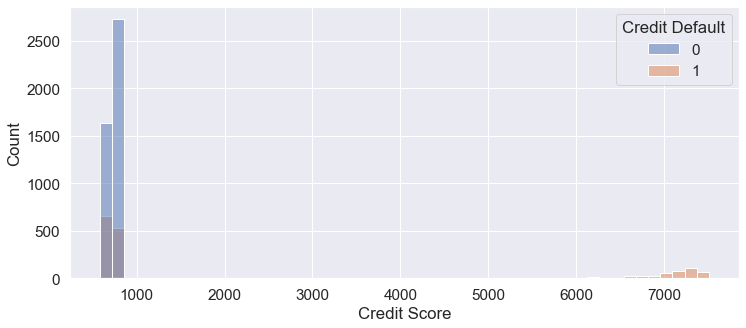

In [20]:
plt.figure(figsize = (12, 5))
sns.histplot( data=train_df, x= 'Credit Score', hue='Credit Default', bins=50)

Распределение Maximum Open Credit и Current Loan Amount

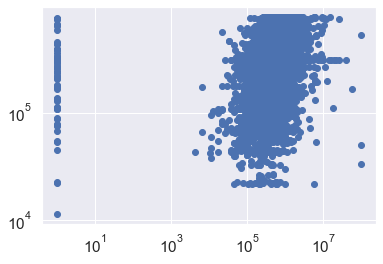

<Figure size 720x576 with 0 Axes>

In [21]:
f, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(train_df['Maximum Open Credit']+1, train_df['Current Loan Amount']+1)
plt.figure(figsize = (10, 8))
plt.show()

In [22]:
train_df['Credit Score. Outlier'] = 0
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score. Outlier'] = 1
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = train_df['Credit Score'] / 10
train_df[['Credit Score. Outlier', 'Credit Score']].describe()

,Credit Score. Outlier,Credit Score
count,7500.000000,5943.000000
mean,0.053333,720.086993
std,0.224712,27.957233
min,0.000000,585.000000
25%,0.000000,708.000000
50%,0.000000,729.000000
75%,0.000000,740.000000
max,1.000000,751.000000


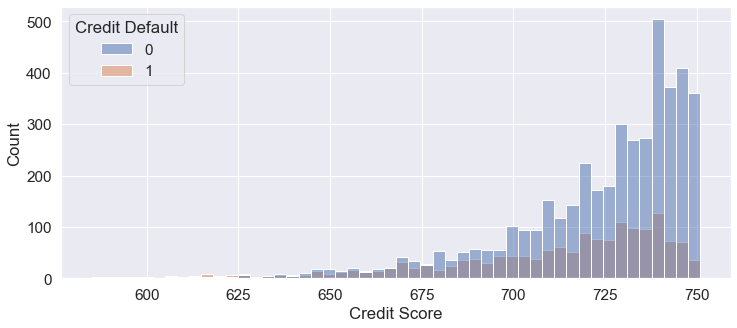

In [23]:
plt.figure(figsize = (12, 5))
sns.histplot( data=train_df, x= 'Credit Score', hue='Credit Default', bins=50);

Annual Income

Пропуски меняем на 0 и помечаем пропущенные значения 

In [24]:
train_df['Annual_Income_nan'] = 0
train_df['Annual_Income_nan'] = train_df['Annual Income'].isna() * 1
AI_median = train_df['Annual Income'].median()
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = AI_median
train_df[['Annual Income', 'Annual_Income_nan']].describe()

,Annual Income,Annual_Income_nan
count,7.500000e+03,7500.000000
mean,1.325286e+06,0.207600
std,7.567551e+05,0.405616
min,1.645970e+05,0.000000
25%,9.311330e+05,0.000000
50%,1.168386e+06,0.000000
75%,1.499974e+06,0.000000
max,1.014934e+07,1.000000


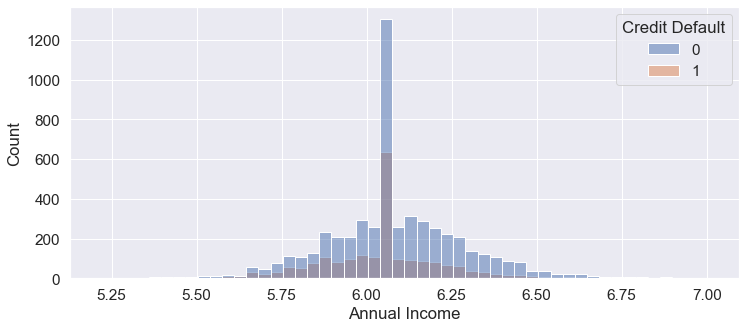

In [25]:
train_df['Annual Income'] =  np.log10(train_df['Annual Income'] + 1)

plt.figure(figsize = (12, 5))
sns.histplot( data=train_df, x= 'Annual Income', hue='Credit Default', bins=50);

Current Credit Balance

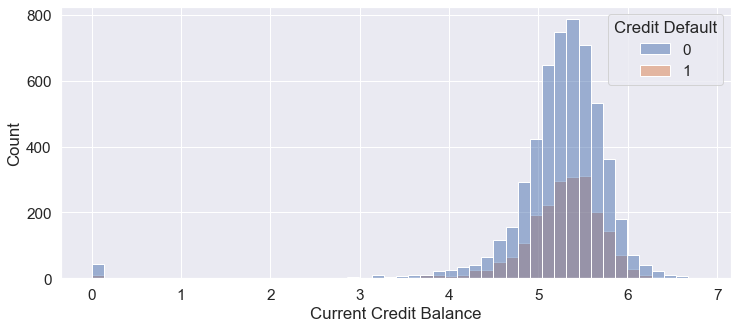

In [26]:
train_df['Current Credit Balance'] =  np.log10(train_df['Current Credit Balance'] + 1)

plt.figure(figsize = (12, 5))
sns.histplot( data=train_df, x= 'Current Credit Balance', hue='Credit Default', bins=50);

Years in current job

Меняем пропуски на моду и помечаем пропуски

In [27]:
train_df.loc[train_df['Years in current job'].isnull(), 'Years in current job'] = train_df['Years in current job'].mode()[0]

Months since last delinquent

Меняем пропуски на 0 и помечаем пропущенные значения

In [28]:
train_df['Months since last delinquent. nan'] = 0
train_df['Months since last delinquent. nan'] = train_df['Months since last delinquent'].isna() * 1
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
train_df[['Months since last delinquent. nan', 'Months since last delinquent']].describe()

,Months since last delinquent. nan,Months since last delinquent
count,7500.000000,7500.000000
mean,0.544133,15.815200
std,0.498082,22.649441
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,29.000000
max,1.000000,118.000000


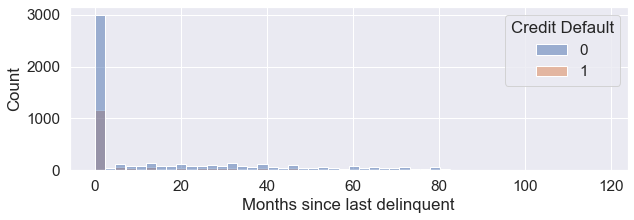

In [29]:
plt.figure(figsize = (10, 3))
sns.histplot( data=train_df, x= 'Months since last delinquent', hue='Credit Default', bins=50);

Bankruptcies

Заменим пропуски на 0 и пометим их

In [30]:
train_df.loc[train_df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
train_df.loc[train_df['Bankruptcies'] > 0, 'Bankruptcies'] = 1

Credit Score

Заменим пропуски на медиану и пометим пропуски

In [31]:
SCORE_median = train_df['Credit Score'].median()
train_df['Credit Score. nan'] = 0
train_df['Credit Score. nan'] = train_df['Credit Score'].isna() * 1
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = SCORE_median
train_df[['Credit Score. nan', 'Credit Score']].describe()

,Credit Score. nan,Credit Score
count,7500.000000,7500.000000
mean,0.207600,721.937333
std,0.405616,25.147440
min,0.000000,585.000000
25%,0.000000,715.000000
50%,0.000000,729.000000
75%,0.000000,738.000000
max,1.000000,751.000000


Maximum Open Credit

In [32]:
train_df['Maximum Open Credit'] =  np.log10(train_df['Maximum Open Credit']+1)
train_df['Maximum Open Credit'].describe()

count    7500.000000
mean        5.625900
std         0.638840
min         0.000000
25%         5.445963
50%         5.679573
75%         5.899548
max         8.000000
Name: Maximum Open Credit, dtype: float64

Current Loan Amount

In [33]:
train_df['Current Loan Amount'] =  np.log10(train_df['Current Loan Amount']+1)
train_df['Current Loan Amount'].describe()

count    7500.000000
mean        5.414096
std         0.277345
min         4.050882
25%         5.255682
50%         5.490757
75%         5.598714
max         5.897094
Name: Current Loan Amount, dtype: float64

Tax Liens 

In [34]:
train_df.loc[train_df['Tax Liens'] > 0, 'Tax Liens'] = 1

Number of Credit Problems

In [35]:
train_df.loc[train_df['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1

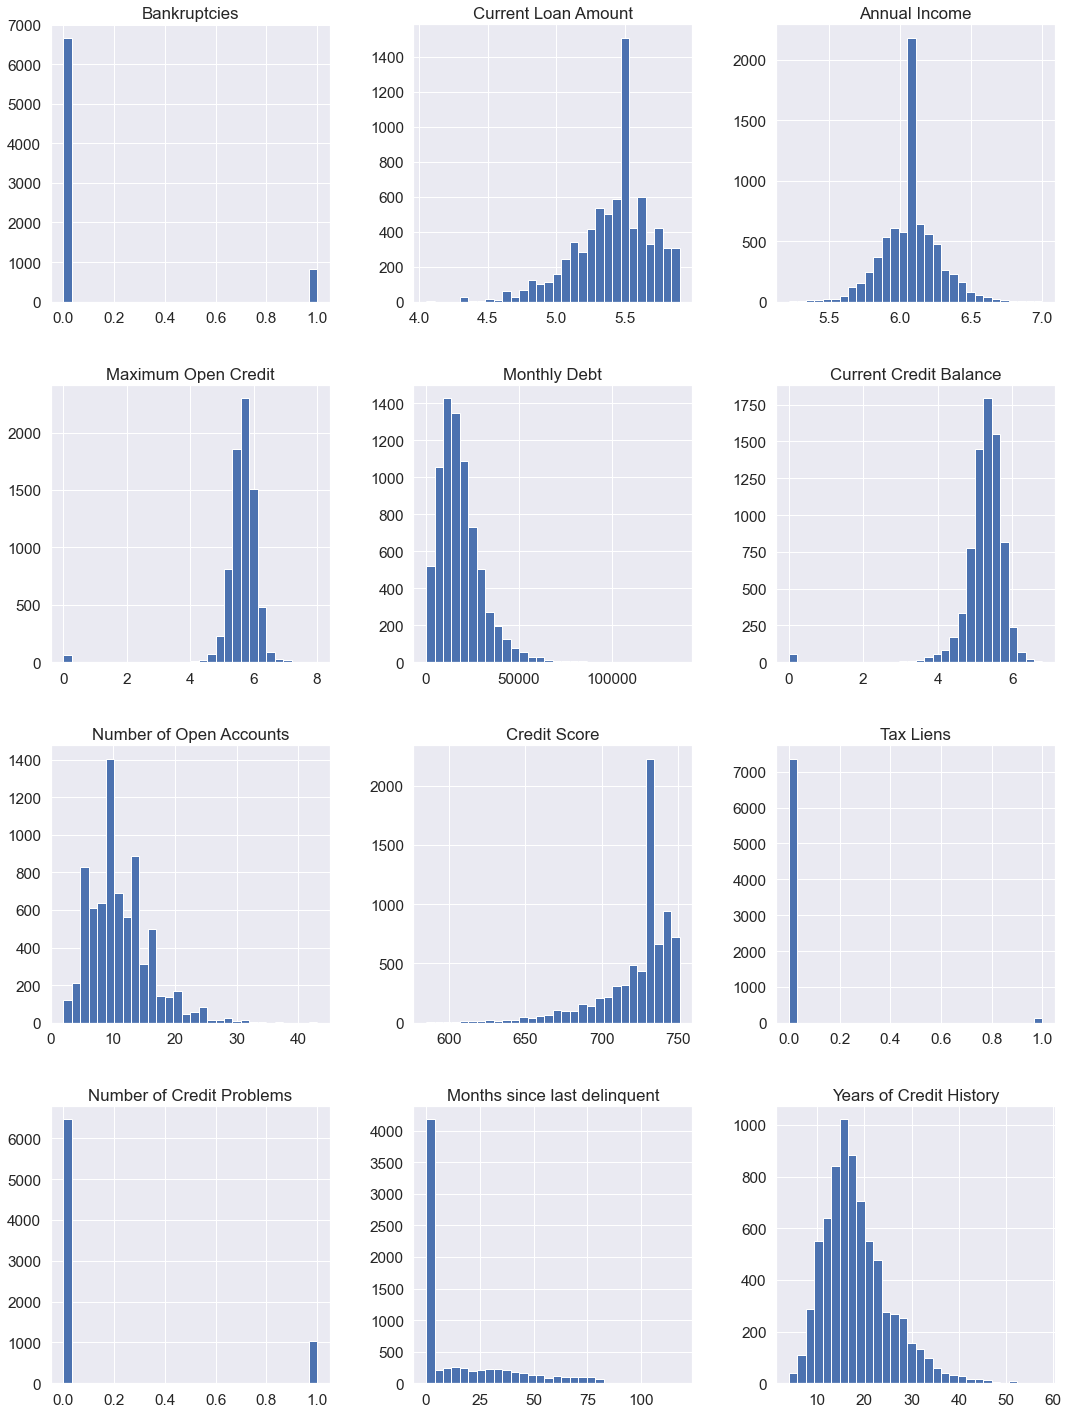

In [36]:
train_df[Numfeatures_names].hist(figsize=(18,25), bins = 30);

Предобработка данных

In [37]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):     
        self.medians = X.median()
  
    def transform(self, X):
        """Трансформация данных"""
       
        # Maximum Open Credit
        max_credit = 99999999.0
        train_df['Maximum Open Credit. Outlier'] = 0
        train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
        train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit
        X['Maximum Open Credit. IsZero'] = 0
        X.loc[X['Maximum Open Credit'] == 0, 'Maximum Open Credit. IsZero'] = 1
        X['Maximum Open Credit'] =  np.log10(X['Maximum Open Credit'] + 1)

        
        # Current Loan Amount
        X['Current Loan Amount. Outlier'] = 0
        CLM_condition = X['Current Loan Amount'] >= 99999999.0
        X.loc[CLM_condition, 'Current Loan Amount. Outlier'] = 1
        X.loc[CLM_condition, 'Current Loan Amount'] = X['Current Loan Amount'].median()
        X['Current Loan Amount'] =  np.log10(X['Current Loan Amount'] + 1)

        
        # Current Credit Balance
        X['Current Credit Balance. IsZero'] = 0
        X.loc[X['Current Credit Balance'] == 0, 'Current Credit Balance. IsZero'] = 1        
        X['Current Credit Balance'] =  np.log10(X['Current Credit Balance'] + 1)
        
        # Credit Score
        X['Credit Score. Outlier'] = 0
        X.loc[X['Credit Score'] > 1000, 'Credit Score. Outlier'] = 1
        X.loc[X['Credit Score'] > 1000, 'Credit Score'] = X['Credit Score'] / 10
         
        
        # Обработка выбросов
        
        # Annual Income
        # заменим пропуски на ноль, пометим пропущенные значения
        X['Annual_Income_nan'] = 0
        X['Annual_Income_nan'] = X['Annual Income'].isna() * 1
        AI_median = X['Annual Income'].median()
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = AI_median
        # Заменим  значение на логарифм
        X['Annual Income'] =  np.log10(X['Annual Income'] + 1)
        
        # Years in current job
        X.loc[X['Years in current job'].isnull(), 'Years in current job'] = X['Years in current job'].mode()[0]
        
        # Months since last delinquent
        # заменим пропуски на ноль, пометим пропущенные значения
        X['Months since last delinquent. nan'] = 0
        X['Months since last delinquent. nan'] = X['Months since last delinquent'].isna() * 1
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
        X.loc[X['Bankruptcies'] > 0, 'Bankruptcies'] = 1

        
        # Credit Score
        # заменим пропуски на медиану, пометим пропущенные значения   
        SCORE_median = X['Credit Score'].median()
        X['Credit Score. nan'] = 0
        X['Credit Score. nan'] = X['Credit Score'].isna() * 1
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = SCORE_median
        
        # Tax Liens
        X.loc[X['Tax Liens'] > 0, 'Tax Liens'] = 1
        
        # Number of Credit problems
        X.loc[X['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
        
        # заменим оставшиеся пропуски на медианы на всякий случай
        X.fillna(self.medians, inplace=True)
        
        return X        

# Генерация признаков #

In [38]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Меняем так, чтобы Long Term были 1, Short Term были 0

In [39]:
train_df['Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})
train_df['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

Years in current job

In [40]:
train_df['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Меняем на числовые значения

In [41]:
train_df['Years in current job'] = train_df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':1, 
                                                                       '2 years':2, 
                                                                       '3 years':3, 
                                                                       '4 years':4, 
                                                                       '5 years':5, 
                                                                       '6 years':6, 
                                                                       '7 years':7,
                                                                       '8 years':8,
                                                                       '9 years':9,
                                                                       '10+ years':10})
train_df['Years in current job'].value_counts()

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [42]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [43]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'], prefix='Purpose')], axis=1)
train_df.drop('Purpose', axis=1, inplace=True)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Maximum Open Credit. Outlier,Maximum Open Credit Outlier,Current Loan Amount. Outlier,Credit Score. Outlier,Annual_Income_nan,Months since last delinquent. nan,Credit Score. nan,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,5.683126,10,0.0,11.0,26.3,5.836299,1.0,0.0,1.0,0,5.490764,4.675659,7914.0,749.0,0,0,NaN,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,6.010931,10,0.0,15.0,15.3,6.072519,0.0,0.0,0.0,1,5.423195,5.596567,18373.0,737.0,1,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,5.875879,8,0.0,11.0,35.0,6.072777,0.0,0.0,0.0,0,5.490764,5.489100,13651.0,742.0,0,0,NaN,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,5.905833,6,0.0,8.0,22.5,5.168500,1.0,0.0,1.0,0,5.084208,4.981619,11338.0,694.0,0,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,5.890010,8,0.0,13.0,13.6,5.586404,1.0,0.0,0.0,0,5.099822,4.969928,7180.0,719.0,0,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [44]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Сделаем допущение, что Home Mortgage и Have Mortgage = одно и то же

In [45]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [46]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'],  prefix='Home Ownership')], axis=1)
train_df.drop('Home Ownership', axis=1, inplace=True)
train_df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Maximum Open Credit. Outlier,Maximum Open Credit Outlier,Current Loan Amount. Outlier,Credit Score. Outlier,Annual_Income_nan,Months since last delinquent. nan,Credit Score. nan,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,5.683126,10,0.0,11.0,26.3,5.836299,1.0,0.0,1.0,0,5.490764,4.675659,7914.0,749.0,0,0,NaN,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,6.010931,10,0.0,15.0,15.3,6.072519,0.0,0.0,0.0,1,5.423195,5.596567,18373.0,737.0,1,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5.875879,8,0.0,11.0,35.0,6.072777,0.0,0.0,0.0,0,5.490764,5.489100,13651.0,742.0,0,0,NaN,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,5.905833,6,0.0,8.0,22.5,5.168500,1.0,0.0,1.0,0,5.084208,4.981619,11338.0,694.0,0,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5.890010,8,0.0,13.0,13.6,5.586404,1.0,0.0,0.0,0,5.099822,4.969928,7180.0,719.0,0,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Класс предобработки #


In [47]:
class FeatureGenetator():
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # Term
        X['Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':1, 
                                                                       '2 years':2, 
                                                                       '3 years':3, 
                                                                       '4 years':4, 
                                                                       '5 years':5, 
                                                                       '6 years':6, 
                                                                       '7 years':7,
                                                                       '8 years':8,
                                                                       '9 years':9,
                                                                       '10+ years':10})
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Home Ownership')], axis=1)
        X.drop('Home Ownership', axis=1, inplace=True)
        
        # Purpose
        X = pd.concat([X, pd.get_dummies(X['Purpose'], prefix='Purpose')], axis=1)
        X.drop('Purpose', axis=1, inplace=True)
        
        return X

# Построение модели #

In [48]:
train_df_read = reduce_mem_usage(pd.read_csv(TRAIN_DATASET_PATH))
test_df_read = reduce_mem_usage(pd.read_csv(TEST_DATASET_PATH))

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.58 MB
Decreased by 40.4%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.19 MB
Decreased by 37.5%


In [49]:
target_name = 'Credit Default'
X = train_df_read.drop(columns=target_name)
y = train_df_read[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [50]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df_read = preprocessor.transform(test_df_read)

print(X_train.shape, X_valid.shape, test_df_read.shape)

(5025, 23) (2475, 23) (2500, 23)


In [51]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)  

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df_read = features_gen.transform(test_df_read)

print(X_train.shape, X_valid.shape, test_df_read.shape)

(5025, 38) (2475, 39) (2500, 38)


In [52]:
features_names = X_train.columns.tolist()

In [53]:
X_train = X_train[features_names]
X_valid = X_valid[features_names]
test_df_read = test_df_read[features_names]

In [54]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df_read.isna().sum().sum()

(0, 0, 0)

In [55]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.604734576757532

In [56]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20)

In [57]:
%%time
params = {'iterations':[5, 7, 10, 20, 30, 50, 200, 500],
          'max_depth':[3, 5, 7, 10]}
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6857001452
bestIteration = 0

0:	loss: 0.6857001	best: 0.6857001 (0)	total: 201ms	remaining: 6.23s

bestTest = 0.6857001452
bestIteration = 0

1:	loss: 0.6857001	best: 0.6857001 (0)	total: 245ms	remaining: 3.67s

bestTest = 0.6950796676
bestIteration = 7

2:	loss: 0.6950797	best: 0.6950797 (2)	total: 272ms	remaining: 2.63s

bestTest = 0.6950796676
bestIteration = 7

3:	loss: 0.6950797	best: 0.6950797 (2)	total: 346ms	remaining: 2.42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6950796676
bestIteration = 7

4:	loss: 0.6950797	best: 0.6950797 (2)	total: 425ms	remaining: 2.29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6950796676
bestIteration = 7

5:	loss: 0.6950797	best: 0.6950797 (2)	total: 511ms	remaining: 2.21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6950796676
bestIteration = 7

6:	loss: 0.6950797	best: 0.6950797 (2)	total: 589ms	remaining: 2.1s
Stopped by overfitting detector  (20 iterations 

In [58]:
final_model = catb.CatBoostClassifier(silent=True, max_depth=2,
                                      iterations=7, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20)

In [59]:
%%time
final_model.fit(X_train, y_train)

evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      3631
           1       0.47      0.68      0.55      1394

    accuracy                           0.69      5025
   macro avg       0.66      0.69      0.66      5025
weighted avg       0.74      0.69      0.71      5025

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1756
           1       0.46      0.66      0.54       719

    accuracy                           0.68      2475
   macro avg       0.65      0.67      0.65      2475
weighted avg       0.72      0.68      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1210  546
1                246  473
Wall time: 322 ms


In [60]:
final_predictions = final_model.predict(test_df_read)
final_predictions

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [61]:
credit_scoring_results = pd.DataFrame()
credit_scoring_results['Id'] = test_df.index
credit_scoring_results['Credit Default'] = pd.Series(final_predictions)
credit_scoring_results.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [62]:
credit_scoring_results.shape

(2500, 2)

In [63]:
credit_scoring_results.to_csv('credit_scoring_results.csv', index = False)